In [1]:
import numpy as np
import pandas as pd
import pickle
import os
import glob
import copy
import csv
import matplotlib.pyplot as plt
from collections import Counter, OrderedDict
from scipy import signal, fftpack, stats
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from operator import itemgetter, attrgetter
import seaborn as sns

In [2]:
transgenics = os.listdir('CoBar-Dataset')
transgenics.remove('PR')

In [3]:
def load_data(xp):
    genDict = np.load(f'CoBar-Dataset/{xp}/U3_f/genotype_dict.npy', allow_pickle=True).item()
    with open(f'CoBar-Dataset/{xp}/U3_f/{xp}_U3_f_trackingData.pkl', 'rb') as f:
        data = pickle.load(f)
    
    print(f'{xp} - Data dimension: {data.shape}')
    
    metadata = np.array([list(item) for item in data.index.values])
    
    print(f'{xp} - Metadata dimension: {metadata.shape}')
    
    return genDict, data, metadata

In [4]:
def get_data_per_fly_per_xp():   
    dict_data = {}
    dict_metadata = {}
    
    stim_col = 1
    xp_col = 3
    fly_col = 4
    
    for strain in transgenics:
        genDict, data, metadata = load_data(strain)
    
        pretarsi=["LFclaw", "LHclaw", "LMclaw", "RFclaw", "RHclaw", "RMclaw"]
        pretarsi_data = data[pretarsi]

        xps = np.unique(metadata[:,xp_col])
        flies = np.unique(metadata[:,fly_col])

        for xp in xps:
            xp_idx = np.where(metadata[:,xp_col] == xp)[0]

            xp_metadata = metadata[xp_idx]
            xp_data = pretarsi_data.iloc[xp_idx]

            for fly in flies:
                fly_idx = np.where(xp_metadata[:,fly_col] == fly)[0]

                xp_fly_metadata = xp_metadata[fly_idx]

                xp_fly_data = xp_data.iloc[fly_idx]
                
                xp_fly_metadata = np.append(xp_fly_metadata, np.array(range(len(xp_fly_metadata))).reshape(-1,1), axis=1)
                
                if not(xp_fly_data.empty):
                    dict_metadata[xp+fly] = np.array(sorted(xp_fly_metadata, key=lambda x: (int(x[stim_col][-1]), x[stim_col])))
                    idx_sort = np.array(list(map(int,dict_metadata[xp+fly][:,-1])))
                    dict_data[xp + fly] = np.array(xp_fly_data)[idx_sort,:]
    
    return dict_data, dict_metadata

In [5]:
dict_data, dict_metadata = get_data_per_fly_per_xp()

MDN - Data dimension: (28770, 70)
MDN - Metadata dimension: (28770, 6)
SS01049 - Data dimension: (26385, 70)
SS01049 - Metadata dimension: (26385, 6)
SS01054 - Data dimension: (31162, 70)
SS01054 - Metadata dimension: (31162, 6)
SS01540 - Data dimension: (26361, 70)
SS01540 - Metadata dimension: (26361, 6)
SS02111 - Data dimension: (26396, 70)
SS02111 - Metadata dimension: (26396, 6)
SS02279 - Data dimension: (28776, 70)
SS02279 - Metadata dimension: (28776, 6)
SS02377 - Data dimension: (28764, 70)
SS02377 - Metadata dimension: (28764, 6)
SS02608 - Data dimension: (28740, 70)
SS02608 - Metadata dimension: (28740, 6)
SS02617 - Data dimension: (26355, 70)
SS02617 - Metadata dimension: (26355, 6)


In [ ]:
'''preproc_data = {}

n_scales = 20
stim_col = 1
# fps = 80

for (key, pretarsi_data) in dict_data.items():
    preproc_data[key] = np.zeros_like(pretarsi_data)
    
    pretarsi_metadata = dict_metadata[key]   
    pretarsi_off_data = pretarsi_data[list(map(lambda x: str.find(x, 'off') == 0, pretarsi_metadata[:,stim_col]))]
    
    for i in range(pretarsi_data.shape[1]):
        # Median filter
        filt = signal.medfilt(pretarsi_data[:,i], kernel_size=3)
        
        # Discard low-variance frames (during off periods)
        # pretarsi_off_data = 
        
        # Z-score normalization
        preproc_data[key][:,i] = stats.zscore(filt)'''

In [6]:
wavelet_data = {}

n_scales = 20
fps = 80
f_min = 1
f_max = fps/2
logvar_thresh = -6.

for (key, data) in dict_data.items():
    wavelet_data[key] = np.zeros((list(data.shape) + [n_scales]))
    
    pretarsi_metadata = dict_metadata[key]
    
    # Wavelet transformation
    for i in range(data.shape[1]):
        sig = abs(signal.cwt(data[:,i], signal.morlet2, np.geomspace(f_min, f_max, n_scales)).T)
    
        wavelet_data[key][:,i,:] = sig
    
    wavelet_data[key] = wavelet_data[key].reshape(wavelet_data[key].shape[0], wavelet_data[key].shape[1]*wavelet_data[key].shape[2])
    
    '''# Low-energy frame rejection    
    low_var_idx = []
    for t in range(wavelet_data[key].shape[0]):
        # Select 'off-period' data
        if str.find(pretarsi_metadata[t, stim_col], 'off') == 0:
            # Discard low variance data
            if np.log(wavelet_data[key][t,:].var()) < logvar_thresh:
                low_var_idx.append(t)
    
    wavelet_data[key] = np.delete(wavelet_data[key], low_var_idx, 0)'''
    
    # Frame-normalization
    for t in range(wavelet_data[key].shape[0]):
        wavelet_data[key][t,:] = wavelet_data[key][t,:]/(wavelet_data[key][t,:].sum())

In [7]:
def save_obj(obj, name):
    with open('data/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [8]:
save_obj(wavelet_data, 'wavelet_data')

In [321]:
wavelet_test.sum(1).shape

(2400,)

In [10]:
dict_embedded_data = {}

for i, (key, data) in enumerate(wavelet_data.items()):
    print(f'{i+1}/{len(wavelet_data)}')
    dict_embedded_data[key] = TSNE(n_components=2).fit_transform(data)

1/105
2/105
3/105
4/105
5/105
6/105
7/105
8/105
9/105
10/105
11/105
12/105
13/105
14/105
15/105
16/105
17/105
18/105
19/105
20/105
21/105
22/105
23/105
24/105
25/105
26/105
27/105
28/105
29/105
30/105
31/105
32/105
33/105
34/105
35/105
36/105
37/105
38/105
39/105
40/105
41/105
42/105
43/105
44/105
45/105
46/105
47/105
48/105
49/105
50/105
51/105
52/105
53/105
54/105
55/105
56/105
57/105
58/105
59/105
60/105
61/105
62/105
63/105
64/105
65/105
66/105
67/105
68/105
69/105
70/105
71/105
72/105
73/105
74/105
75/105
76/105
77/105
78/105
79/105
80/105
81/105
82/105
83/105
84/105
85/105
86/105
87/105
88/105
89/105
90/105
91/105
92/105
93/105
94/105
95/105
96/105
97/105
98/105
99/105
100/105
101/105
102/105
103/105
104/105
105/105


In [272]:
save_obj(dict_embedded_data, 'embedded_data')

In [302]:
numPoints = 501

wavelet_test = wavelet_data[next(iter(wavelet_data))]
test = dict_embedded_data[next(iter(dict_embedded_data))]
sigma = 1.5

G = np.exp(-0.5*(XX**2 + YY**2)/(sigma**2)) / (2*np.pi*sigma**2);
maxY = np.ceil(test.max())+1
xx = np.linspace(-maxY, maxY, numPoints)
yy = xx
XX, YY = np.meshgrid(xx, yy)

H, _, _ = np.histogram2d(test[:,0], test[:,1], bins=(xx, yy))

res = signal.convolve(G, H, mode='same')
res *= res > 0

In [320]:
wavelet_test[0,:].shape

(240,)

In [298]:
test.shape

(2400, 2)

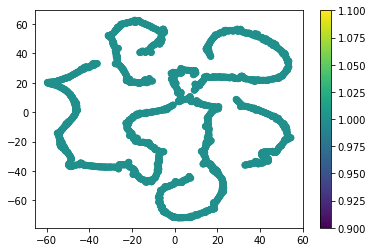

In [305]:
sc = plt.scatter(test[:,0], test[:,1], c = wavelet_test.sum(1))
plt.colorbar(sc)
#plt.colorbar()

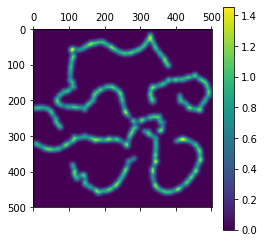

In [294]:
plt.matshow(res)
plt.colorbar()
plt.show()

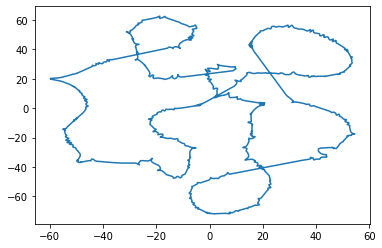

In [263]:
plt.plot(test[:,0], test[:,1])

In [267]:
vals = np.round((test + max(xx))*len(xx)/(2*max(xx))).astype(int);

array([-31, -30, -29, -28, -27, -26, -25, -24, -23, -22, -21, -20, -19,
       -18, -17, -16, -15, -14, -13, -12, -11, -10,  -9,  -8,  -7,  -6,
        -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,   5,   7,   8,
         9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,
        22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,
        35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,
        48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,
        61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,
        74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,
        87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,
       100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
       113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
       126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
       139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 15

In [248]:
wavelet = wavelet_data[next(iter(wavelet_data))]

In [249]:
labels = watershed(-res, connectivity=8)
maxL = labels.max()
maxL

575

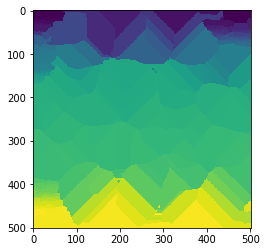

In [250]:
plt.imshow(labels)

In [251]:
G.shape, H.shape, res.shape

((501, 501), (500, 500), (501, 501))

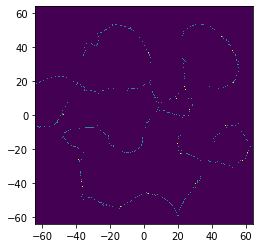

In [252]:
plt.imshow(H, interpolation='nearest', origin='low', extent=[xx[0], xx[-1], yy[0], yy[-1]])

In [253]:
N = test.shape[0]
watershedValues = np.zeros((N,1));
for i in range(N):
    watershedValues[i] = labels[vals[i,1],vals[i,0]];

In [254]:
len(np.unique(labels)), np.unique(labels)[-1], labels.shape

(575, 575, (501, 501))

In [255]:
templates = []

for i in range(maxL):
    if len(np.where(watershedValues==i)[0]) > 0:
        templates.append(wavelet[np.where(watershedValues==i)[0],:])
templateLengths = np.array(list(map(len, templates)))

In [256]:
numPerDataSet = 350
numInGroup = np.round(numPerDataSet*templateLengths/sum(templateLengths))
numInGroup = np.clip(numInGroup, 1, np.max(numInGroup))
sumVal = sum(numInGroup);

In [257]:
numInGroup

array([ 6.,  4.,  4., 10.,  5.,  1.,  1.,  4.,  6.,  5.,  6.,  4.,  8.,
        7.,  4.,  1.,  3.,  1.,  9.,  4.,  2.,  4.,  4.,  7.,  3.,  2.,
        1.,  1.,  7.,  4.,  8.,  1.,  9.,  1.,  1.,  4.,  5.,  6.,  3.,
        1.,  5.,  9.,  1., 13.,  3.,  6.,  8.,  5.,  2.,  7.,  3., 13.,
        2.,  4.,  6.,  4.,  1.,  3.,  5.,  6.,  3.,  4.,  5.,  2.,  1.,
        4.,  5., 12.,  7.,  2.,  5.,  8., 13., 10.,  1.])

In [258]:
N = len(templates)
if sumVal < numPerDataSet:
    q = int(numPerDataSet - sumVal);
    idx = np.random.choice(N,min(q,N));
    numInGroup[idx] += 1;
else:
    if sumVal > numPerDataSet:
        q = int(sumVal - numPerDataSet);
        idx2 = np.where(numInGroup > 1)[0];
        Lq = len(idx2);
        if Lq < q:
            idx2 = range(len(numInGroup));
        idx = np.random.choice(len(idx2),q);
        numInGroup[idx2[idx]] -= 1

In [259]:
idx = numInGroup > templateLengths;
numInGroup[idx] = templateLengths[idx];
cumSumGroupVals = np.append([0],np.cumsum(numInGroup));

In [260]:
cumSumGroupVals

array([  0.,   5.,   9.,  13.,  23.,  27.,  28.,  29.,  33.,  39.,  44.,
        50.,  54.,  62.,  69.,  73.,  74.,  77.,  78.,  87.,  91.,  93.,
        97., 101., 108., 110., 112., 113., 114., 121., 125., 133., 134.,
       143., 144., 145., 149., 154., 160., 163., 164., 169., 178., 179.,
       191., 194., 200., 208., 213., 214., 221., 224., 237., 239., 243.,
       249., 253., 254., 257., 262., 268., 271., 275., 280., 282., 283.,
       287., 292., 304., 311., 313., 318., 326., 339., 349., 350.])

In [261]:
templates[0].shape

(42, 240)

In [213]:
selectedData = []

for j in range(N):      
    #amps = wavelet_data.sum(1)
    #amps = amps[np.where(vals == j)]
    idx2 = np.random.choice(templates[j].shape[0], int(numInGroup[j]))
    selectedData.extend(templates[j][idx2,:]);
    #selectedAmps(cumSumGroupVals(j)+1:cumSumGroupVals(j+1)) = amps(idx2);

In [214]:
np.array(selectedData).shape

(351, 240)

In [271]:
n_embed = 10
numPoints = 501
numPerDataSet = 350

selected_data = {}

for i, (key, data) in enumerate(dict_embedded_data.items()):
    print(f'{i+1}/{len(dict_embedded_data)}')
    knn = NearestNeighbors(n_neighbors=n_embed)
    knn.fit(data)
    
    neighs = np.zeros((data.shape[0], n_embed))
    
    for j in range(data.shape[0]):
        #print(data[j,:]..shape)
        neigh_dist, neigh_ind = knn.kneighbors(data[j,:].reshape(1,-1),return_distance=True)
        #print(neigh_dist.shape)
        #print(neigh_dist)
       
        #sigma = np.median(neigh_dist[:,-1])
        #print(sigma)
        
        neighs[j,:] = neigh_dist
    
    #print(neighs.shape)
    #print(np.median(neighs[:,-1]))
    
    sigma = np.median(neighs[:,-1])
    
    maxY = np.ceil(data.max())+1
    xx = np.linspace(-maxY, maxY, numPoints)
    yy = xx
    XX, YY = np.meshgrid(xx, yy)
    
    G = np.exp(-0.5*(XX**2 + YY**2)/(sigma**2)) / (2*np.pi*sigma**2);
    
    #print(G.shape)
    
    maxY = np.ceil(test.max())+1
    xx = np.linspace(-maxY, maxY, numPoints)
    yy = xx
    XX, YY = np.meshgrid(xx, yy)

    H, _, _ = np.histogram2d(test[:,0], test[:,1], bins=(xx, yy))

    res = signal.convolve(G, H, mode='same')
    res *= res > 0
    
    vals = np.round((data + max(xx))*len(xx)/(2*max(xx))).astype(int);
    vals = np.clip(vals, vals.min(), numPoints-1)
    
    #print(np.unique(vals))
    
    labels = watershed(-res, connectivity=8)
    maxL = labels.max()
    
    N = data.shape[0]
    watershedValues = np.zeros((N,1));
    for k in range(N):
        watershedValues[k] = labels[vals[k,1],vals[k,0]];
    
    #print(np.unique(watershedValues))
    
    wavelet = wavelet_data[key]
    templates = []

    for l in range(maxL):
        if len(np.where(watershedValues==l)[0]) > 0:
            templates.append(wavelet[np.where(watershedValues==l)[0],:])
    templateLengths = np.array(list(map(len, templates)))
    
    #print(templateLengths)

    numInGroup = np.round(numPerDataSet*templateLengths/sum(templateLengths))
    numInGroup = np.clip(numInGroup, 1, np.max(numInGroup))
    sumVal = numInGroup.sum();
    
    #print(numInGroup)
    
    N = len(templates)
    if sumVal < numPerDataSet:
        q = int(numPerDataSet - sumVal);
        idx = np.random.choice(N,min(q,N));
        numInGroup[idx] += 1;
    else:
        if sumVal > numPerDataSet:
            q = int(sumVal - numPerDataSet);
            idx2 = np.where(numInGroup > 1)[0];
            Lq = len(idx2);
            if Lq < q:
                idx2 = range(len(numInGroup));
            idx = np.random.choice(len(idx2),q);
            numInGroup[idx2[idx]] -= 1
    
    idx = numInGroup > templateLengths;
    numInGroup[idx] = templateLengths[idx];
    cumSumGroupVals = np.append([0],np.cumsum(numInGroup));
    
    selectedData = []

    for m in range(N):      
        #amps = wavelet_data.sum(1)
        #amps = amps[np.where(vals == j)]
        idx2 = np.random.choice(templates[m].shape[0], int(numInGroup[m]))
        selectedData.extend(templates[m][idx2,:]);
        #selectedAmps(cumSumGroupVals(j)+1:cumSumGroupVals(j+1)) = amps(idx2);
    
    selected_data[key] = np.array(selectedData)

1/105
2/105
3/105
4/105
5/105
6/105
7/105
8/105
9/105
10/105
11/105
12/105
13/105
14/105
15/105
16/105
17/105
18/105
19/105
20/105
21/105
22/105
23/105
24/105
25/105
26/105
27/105
28/105
29/105
30/105
31/105
32/105
33/105
34/105
35/105
36/105
37/105
38/105
39/105
40/105
41/105
42/105
43/105
44/105
45/105
46/105
47/105
48/105
49/105
50/105
51/105
52/105
53/105
54/105
55/105
56/105
57/105
58/105
59/105
60/105
61/105
62/105
63/105
64/105
65/105
66/105
67/105
68/105
69/105
70/105
71/105
72/105
73/105
74/105
75/105
76/105
77/105
78/105
79/105
80/105
81/105
82/105
83/105
84/105
85/105
86/105
87/105
88/105
89/105
90/105
91/105
92/105
93/105
94/105
95/105
96/105
97/105
98/105
99/105
100/105
101/105
102/105
103/105
104/105
105/105


In [273]:
save_obj(selected_data, 'selected_data')

In [275]:
selected_data[next(iter(selected_data))].shape

(351, 240)

In [281]:
training_data = []

for data in selected_data.values():
    training_data.extend(data)
training_data = np.array(training_data)
training_data.shape

(36883, 240)

In [284]:
# Normalize

for t in range(training_data.shape[0]):
    training_data[t,:] = training_data[t,:]/training_data[t,:].sum()

In [285]:
training_embedded = TSNE(n_components=2).fit_transform(training_data)

In [287]:
training_embedded.shape

(36883, 2)